# AB-Testing

## Data

Self-declared biggest serial businesses company requested.  
They have a new revolutionary design of their site with the intention to increase their current conversion rates of 12% to 13,5% or more.  
So we have to perform ab-test analysis to make a fundamental decision: keep the old design site or introduce the new one.  
At our disposal there is a dataset with information about users and their conversion.

## Task

Make a decision about more attractive design

## Designing the Experiment

Formulating an experiment.  

We don’t know if the new design will be same, better or worse as our control design, so let`s choose a two-tailed test.  

H0: There is no statistically significant difference between conversion rate in control (old site) and test (new site) groups (m0 != m1).  

H1: There is statistically significant difference between conversion rate in control (old site) and test (new site) groups (m0 = m1).

Let`s set a convidence level of 95%.  

Here we have discrete metrics，known also as binomial metrics, that have only two values (0 or 1), such as click-through rate (CTR), conversion rate (CR), bounce rate and etc. That`s why **Pearson's chi-square test** is much better to be chosen.  

## First Look at Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline
import seaborn as sns
import datetime

import scipy.stats as st
import statsmodels.stats.api as sms

import statsmodels.stats.proportion as proportion
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from math import ceil

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/aaubs/data_science_master/main/data/ab_data.csv', parse_dates=[1])

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


Here we have 294 478 rows and 5 columns:

- 'user_id' with user id (int64)    
- 'timestamp' with the beginning of the session (datetime)  
- 'group' with 2 variables: control and treatment (object)  
- 'landing_page' with version of a site: old page and new page (object)  
- 'converted': if user made a purchase (1) or not (0) (int64)

## Data Preprocessing

Let us check for the nan values.

In [5]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There is no missing values.

Let's check for duplicates

In [6]:
df.duplicated().sum()

0

Let`s make sure there is no duplicated user_id

In [7]:
multi_users = df.user_id.value_counts().sort_values(ascending=False)
multi_users[multi_users >= 2]

user_id
805339    2
856917    2
834370    2
703112    2
823617    2
         ..
911462    2
734251    2
826566    2
687205    2
700036    2
Name: count, Length: 3894, dtype: int64

In [8]:
dupli_ids = multi_users[multi_users >= 2].index

In [9]:
round(100 - (dupli_ids.shape[0]/df.shape[0] * 100), 1)

98.7

We have a small percent of duplicated values, so we`ll just remove them

In [10]:
dupli_ids

Index([805339, 856917, 834370, 703112, 823617, 698120, 795297, 923199, 818738,
       915110,
       ...
       839043, 647686, 929326, 678241, 763923, 911462, 734251, 826566, 687205,
       700036],
      dtype='int64', name='user_id', length=3894)

In [11]:
df = df.query('user_id not in @dupli_ids').copy()

Let`s check that everything is correct

In [12]:
display(df.shape[0])


286690

In [13]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
df.user_id.duplicated().sum()

0

In [15]:
df[df.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


Duplicated are gone

Now we have to make sure that treatment group sees only the new page of the site.

In [16]:
display(df.query('group == "treatment"').shape[0])
df.query('group == "treatment" & landing_page == "new_page"').shape[0]

143397

143397

That`s right

## EDA

In [17]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Let`s look at the analysis period.

In [18]:
df['date'] = pd.to_datetime(df['timestamp']).dt.normalize()

In [19]:
display(df.date.min())
display(df.date.max())

Timestamp('2017-01-02 00:00:00')

Timestamp('2017-01-24 00:00:00')

It is 22 days between 2017-01-02 and 2017-01-24

In [20]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286690 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       286690 non-null  int64         
 1   timestamp     286690 non-null  datetime64[ns]
 2   group         286690 non-null  object        
 3   landing_page  286690 non-null  object        
 4   converted     286690 non-null  int64         
 5   date          286690 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 15.3+ MB


We can make a mistake in our calculations if we won`t check the conversion at the last day

In [21]:
last_day = df.query('date == "2017-01-24"').copy()

In [22]:
last_day.date.value_counts()

date
2017-01-24    7345
Name: count, dtype: int64

In [23]:
round(last_day.query('group == "control"')['converted'].mean() * 100, 2)

11.79

In [24]:
round(last_day.query('group == "treatment"')['converted'].mean() * 100, 2)

11.98

There is no some strange values, so let it be

Let`s count the conversion rate in the control group of whole dataframe

In [25]:
round((df.query('group == "control" & converted == 1').shape[0] / df[df.group == 'control'].shape[0]) * 100, 2)

12.02

Let`s count the conversion rate in the treatment group of whole dataframe

In [26]:
round(df.query('group =="treatment"')['converted'].mean() * 100, 2)

11.87

[Text(0.5, 1.0, 'Convertsion rate for each group'),
 Text(0, 0.5, 'Conversion Rate')]

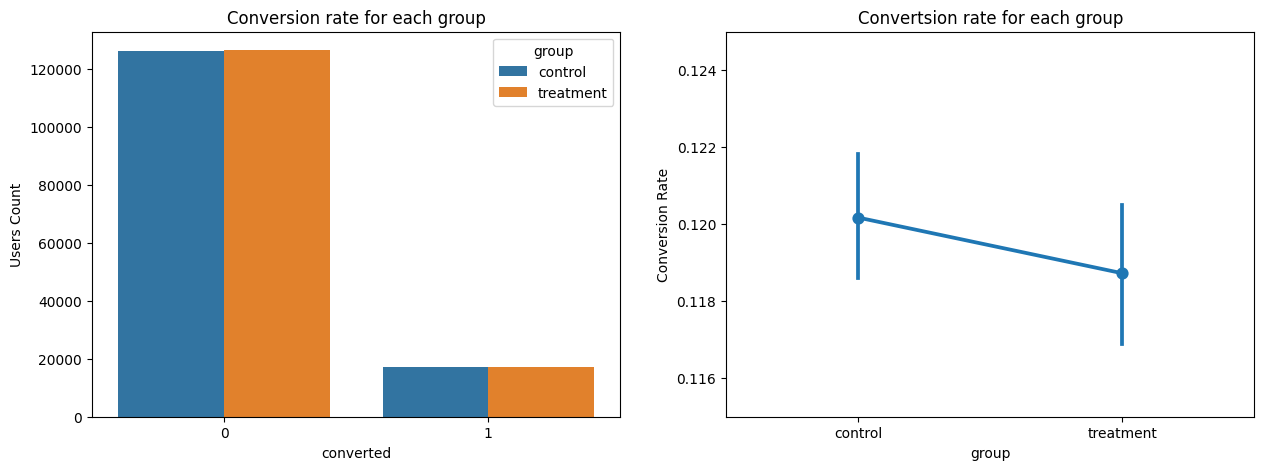

In [27]:
rcParams['figure.figsize'] = 15, 5

fig, ax = plt.subplots(1,2)

sns.countplot(df, x="converted", hue="group", ax=ax[0])
ax[0].set(title="Conversion rate for each group", ylabel="Users Count")

sns.pointplot(df, x="group", y="converted", ax=ax[1])
ax[1].set_ylim([0.115, 0.125])
ax[1].set(title="Convertsion rate for each group", ylabel="Conversion Rate")

In fact, the treatment group shows us worse result.  
But what if it was received by accident.

## Sampling

Let`s set the conversion rate on the level of 12%. We would like to increase our metric to 13,5%.  
Therefore, we created A/B-test to ensure that a new version of a site will certainly increase the conversion.

In [28]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.12, 0.135)

sample_size = (sms.NormalIndPower()
              .solve_power(effect_size, 
                           power=0.9,  #power of a test (defualt is 0.8)
                           alpha=0.05, #p-value
                           ratio=1
                          )
             )

sample_size = ceil(sample_size)
print(sample_size)

10382


In [29]:
control = df.query('group == "control"').sample(sample_size)
test = df.query('group == "treatment"').sample(sample_size)

Let`s check if everything is okay.

In [30]:
display(control.shape[0])
test.shape[0]

10382

10382

Now we will concatenate them

In [31]:
ab = pd.concat([control, test], axis = 0).reset_index()

In [32]:
display(ab.head())
ab.shape[0]

,index,user_id,timestamp,group,landing_page,converted,date
0,227926,732322,2017-01-15 04:03:47.881581,control,old_page,0,2017-01-15
1,18591,832030,2017-01-22 16:23:21.401476,control,old_page,0,2017-01-22
2,243285,683410,2017-01-22 18:13:04.294829,control,old_page,0,2017-01-22
3,47413,766641,2017-01-10 01:19:05.100824,control,old_page,0,2017-01-10
4,227460,837647,2017-01-16 12:28:11.167648,control,old_page,0,2017-01-16


20764

In [33]:
ab.group.value_counts()

group
control      10382
treatment    10382
Name: count, dtype: int64

That`s fine. Now we'll see at the conversion rates of each groups.

In [34]:
cr = ab.groupby('group')['converted']
cr = cr.agg([np.mean, np.std, st.sem]).copy()
cr.style.format('{:.3f}')

,mean,std,sem
group,,,
control,0.118,0.322,0.003
treatment,0.123,0.329,0.003


## AB-Test

Let`s remember the hypothesis

H0: conversion rate of control group **equals** to conversion rate of treatment group.

H1: conversion rate of control verson **does not equal** to conversion rate of treatment group.  

We'll use Pearson Chi Stats.

### Pearson's chi-square test

Preparing of the table for chi test.

In [38]:
table = pd.crosstab(ab.group, ab.converted)
table

converted,0,1
group,,
control,9159,1223
treatment,9104,1278


In [39]:
# chi-squared test 
stat, p, dof, expected = st.chi2_contingency(table)
print("fredoom of degree=%d"% dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = st.chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1-prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

fredoom of degree=1
[[9131.5 1250.5]
 [9131.5 1250.5]]
probability=0.950, critical=3.841, stat=1.326
Independent (fail to reject H0)
significance=0.050, p=0.250
Independent (fail to reject H0)


Another python library solution

In [40]:
nobs = [control.converted.count(), test.converted.count()]
successes = [control.converted.sum(), test.converted.sum()]
chi2stat, pval, table = proportion.proportions_chisquare(successes, nobs)

alpha = 0.05

if pval < alpha:
    print('There is no reason to reject H0')
else:
    print('Failed to reject H0')

Failed to reject H0


## Conclusion

There is no reason to reject H0. It means that control and treatment group are significantly similar.  
New designed site have no advantages over the old designed site.